In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from fxdayu_alphaman.factor.factor import Factor

class Factor_Volume001(Factor):

    c = 6

    def calculate_volume001(self, data):
        # 逐支股票计算volume003因子
        candle_data = data[1].dropna()
        if len(candle_data) == 0:
            return
        high = candle_data["high"]
        volume = candle_data["volume"]
        adv_s = self.ts_mean(volume, 10)
        factor_volume001 = - self.correlation(high, adv_s, self.c) #计算因子值
        factor_volume001.index = candle_data.index
        factor_volume001 = pd.DataFrame(factor_volume001)
        factor_volume001.columns = [data[0],]
        return  factor_volume001

    def factor_calculator(self, pn_data):
        # volume001
        factor_volume001 = map(self.calculate_volume001, pn_data.iteritems())
        factor_volume001 = pd.concat(factor_volume001, axis=1)
        factor_volume001 = self.winsorize(factor_volume001) #去极值
        factor_volume001 = self.standardize(factor_volume001) #标准化
#         factor_volume001 = self.neutralize(factor_volume001, factorIsMV=False) #行业、市值中性化
        factor_volume001 = self.factor_df_to_factor_mi(factor_volume001) #格式标准化
#         factor_volume001 = self.get_factor_by_rankScore(factor_volume001, ascending=True) # 将因子用排序分值重构，并处理到0-1之间(默认为升序——因子越大 排序分值越大(越好)
                                                                                          # 具体根据因子对收益的相关关系而定，为正则应用升序,为负用降序)
        return factor_volume001

class Factor_Volume003(Factor):

    d = 7
    s = 8
    c = 14

    def calculate_volume003(self, data):
        # 逐支股票计算volume003因子
        candle_data = data[1].dropna()
        if len(candle_data) == 0:
            return
        high = candle_data["high"]
        volume = candle_data["volume"]
        #核心算法
        factor_volume003 = - self.correlation(self.slope(high, self.s), self.slope(self.delta(np.log(volume), self.d), self.s),self.c) #计算因子值
        factor_volume003.index = candle_data.index
        factor_volume003 = pd.DataFrame(factor_volume003)
        factor_volume003.columns = [data[0],]
        return  factor_volume003

    def factor_calculator(self, pn_data):
        # volume003

        factor_volume003 = map(self.calculate_volume003, pn_data.iteritems())
        factor_volume003 = pd.concat(factor_volume003, axis=1)
        # factor_volume003 = self.winsorize(factor_volume003) #去极值
        # factor_volume003 = self.standardize(factor_volume003) #标准化
        # factor_volume003 = self.neutralize(factor_volume003, factorIsMV=False) #行业、市值中性化
        factor_volume003 = self.factor_df_to_factor_mi(factor_volume003) #格式标准化
        factor_volume003 = self.get_factor_by_rankScore(factor_volume003, ascending=True) # 将因子用排序分值重构，并处理到0-1之间(默认为升序——因子越大 排序分值越大(越好)
                                                                                          # 具体根据因子对收益的相关关系而定，为正则应用升序,为负用降序)
        return factor_volume003

In [2]:
from datetime import datetime
from fxdayu_data import DataAPI
from fxdayu_alphaman.factor.utility import standard_code_style
from fxdayu_alphaman.factor.admin import Admin

DataAPI.set_file("X:\Users\caimeng\.fxdayu\data/config.py")

[Errno 2] No such file or directory: 'X:\\Users\\caimeng\\.fxdayu\\data/config.py'


In [3]:
# 测试参数设置
start = datetime(2015, 1, 1)
end = datetime(2017, 4, 18, 15)
periods = (1, 5, 10)


codes = DataAPI.candle.find("HS300")

data_config={"freq": "D", "api": "candle", "adjust":"after"}

# 获取数据
PN = DataAPI.candle(codes, "D", ('high','close', 'volume'), start=start, end=end)
prices = PN.minor_xs('close')
print PN
print prices

TypeError: unhashable type: 'list'

In [7]:
def manage_factors_value_test(factor_name_list,data_config_dict):
    # admin测试 -获得多个因子结果
    factor_admin = Admin(*factor_name_list)
    result = factor_admin.get_all_factors_value(codes,start,end,all_Factors_dict=factor_dict,
                                                all_factors_data_config_dict=data_config_dict
                                                )

    return(factor_admin , result)

#######################################################

#确定要载入的因子名称
factor_name_list = ["Factor_Volume003", "Factor_Volume001"]
#确定因子的类
factor_dict = {"Factor_Volume001": Factor_Volume001(),"Factor_Volume003": Factor_Volume003()}

#逐个配置因子需要的数据类型
data_config_dict = {"Factor_Volume003":data_config,"Factor_Volume001":data_config}

# admin测试 -获得多个因子结果
factor_admin , result = manage_factors_value_test(factor_name_list,data_config_dict)

In [8]:
#######################################
factor_name_list,factor_value_list = result.keys(),result.values()

In [9]:
# 因子加权合成

# 1)　计算因子ｉｃ序列
ic_df = factor_admin.get_factors_ic_df(factor_name_list,factor_value_list,codes,start,end,periods=(1,5,10),quantiles=5,price=prices)
# 2) 计算因子权重
holding_period = 10
ic_weight_df = factor_admin.get_ic_weight_df(ic_df[holding_period],holding_period,rollback_period=30)


# 3)计算加权合成的因子
new_factor = factor_admin.ic_cov_weighted_factor(factor_name_list,factor_value_list,ic_weight_df)
print new_factor

# 4)查看合成的因子表现
perf = factor_admin.calculate_performance(new_factor.name,new_factor.multifactor_value,start,end,periods = (1,5,10),quantiles=5,price = prices)
print(perf.mean_ic)

E:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                                        1         5        10    factor  \
date                asset                                                 
2015-03-09 15:00:00 000001.XSHE -0.026855  0.089046  0.090459  0.281097   
                    000002.XSHE -0.016367  0.022095  0.093290  1.854641   
                    000009.XSHE  0.063366  0.069307  0.096370 -0.108767   
                    000027.XSHE  0.014423  0.074038  0.212500  1.830436   
                    000039.XSHE -0.001508  0.043878  0.095316  0.913268   
                    000060.XSHE -0.016323  0.003436  0.103093  0.042210   
                    000061.XSHE -0.008505  0.007796  0.063076  0.047121   
                    000063.XSHE -0.006006  0.021522  0.095596 -0.346057   
                    000100.XSHE  0.023211  0.007737  0.154739  0.302999   
                    000156.XSHE  0.037856  0.110772  0.300305 -0.539764   
                    000157.XSHE -0.003185  0.019108  0.082803  1.815120   
                    00033

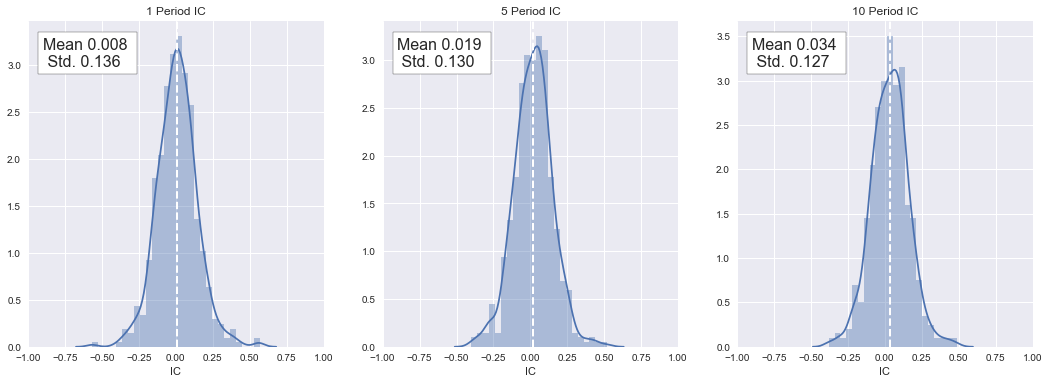

E:\Anaconda2\lib\site-packages\alphalens\plotting.py:215: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(ic, 22).plot(ax=a,


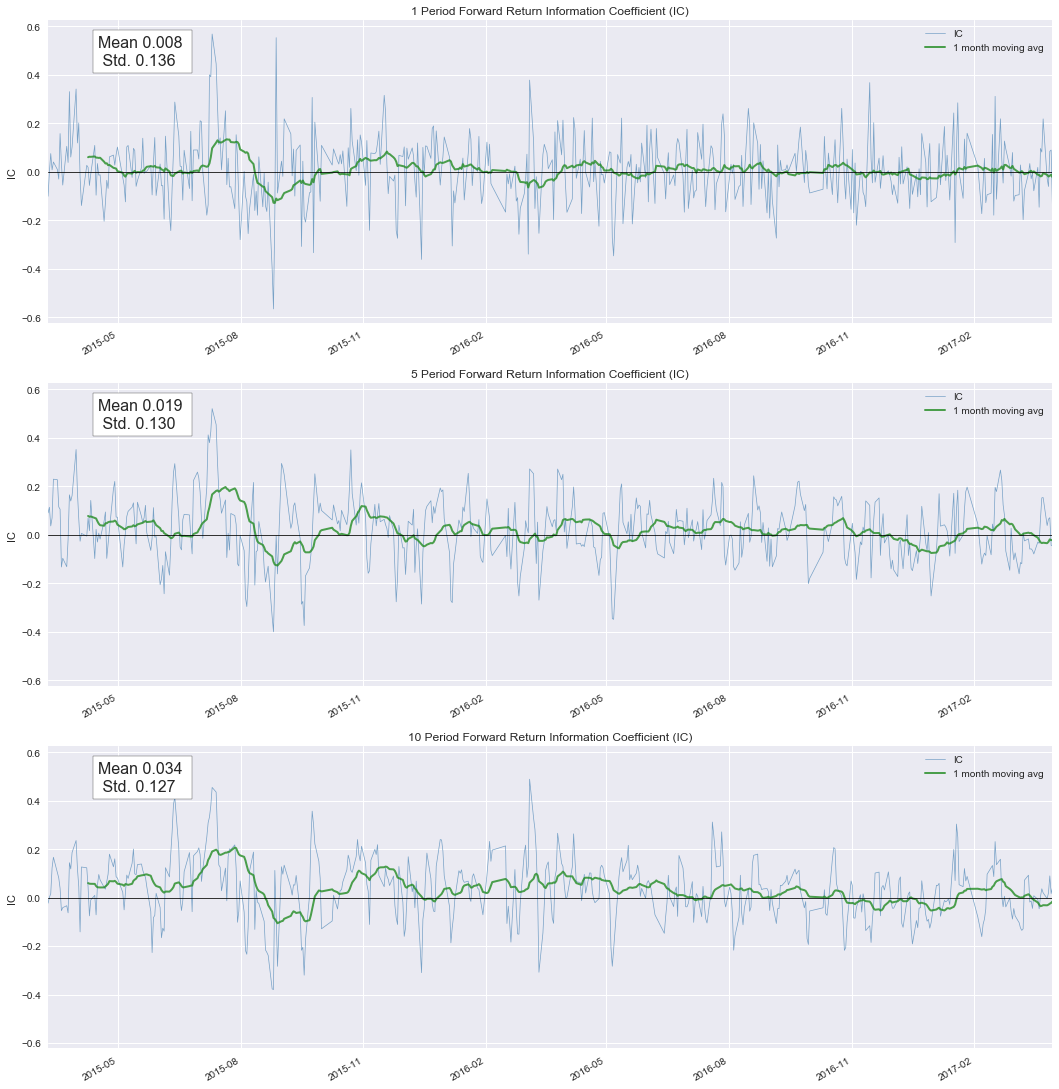

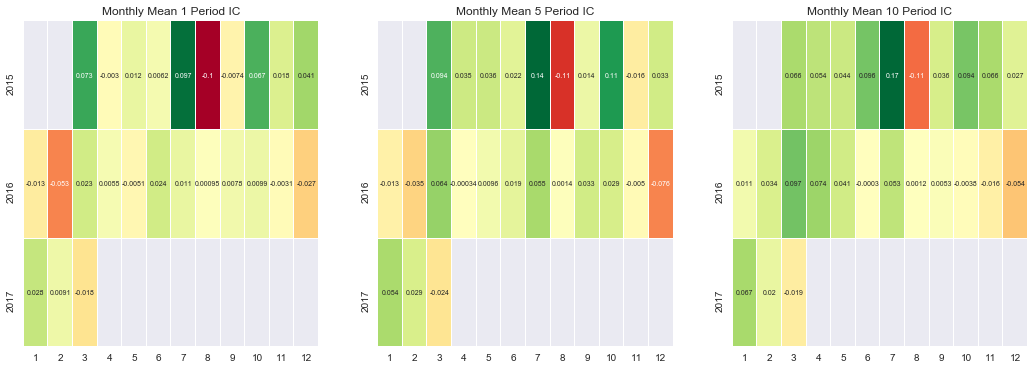

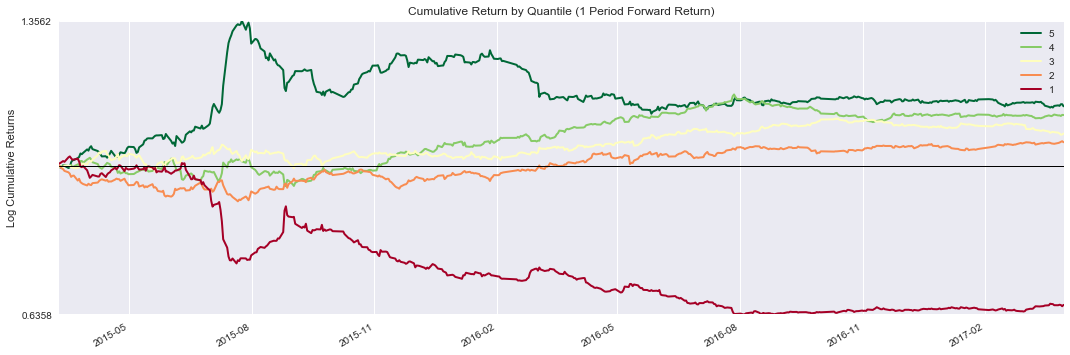

E:\Anaconda2\lib\site-packages\alphalens\plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))


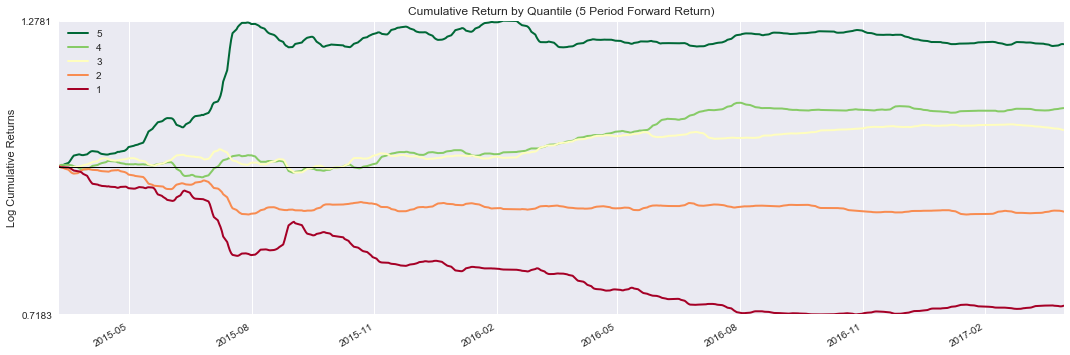

E:\Anaconda2\lib\site-packages\alphalens\plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=10).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))


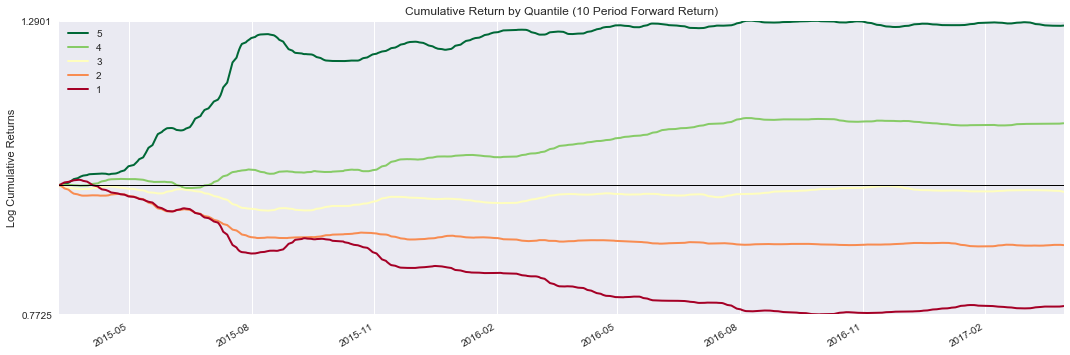

In [10]:
from alphalens import plotting
import matplotlib.pyplot as plt
plotting.plot_ic_hist(perf.ic)
plt.show()
plotting.plot_ic_ts(perf.ic)
plt.show()
plotting.plot_monthly_ic_heatmap(perf.mean_ic_by_M)
plt.show()

# 按quantile画出累积持有收益
for i in [1, 5, 10]:
    plotting.plot_cumulative_returns_by_quantile(perf.mean_return_by_q, period=i)
    plt.show()

In [11]:
# new_factor.multifactor_value.unstack()
import alphalens
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(new_factor.multifactor_value, prices, quantiles=5)

cond = factor_data['factor_quantile'] == 5
Q5 = factor_data[cond]
stocks = pd.Series(True, index=Q5.index)
stocks = stocks.unstack()
stocks[stocks != True] = False
print(stocks)
stocks.to_excel('C:/Users/small/Desktop/july_first/multi_Selection.xlsx')

asset               000001.XSHE 000002.XSHE 000008.XSHE 000009.XSHE  \
date                                                                  
2015-03-09 15:00:00       False        True       False       False   
2015-03-10 15:00:00       False        True       False       False   
2015-03-11 15:00:00       False       False       False       False   
2015-03-12 15:00:00       False       False       False       False   
2015-03-13 15:00:00       False       False       False       False   
2015-03-16 15:00:00       False        True       False       False   
2015-03-17 15:00:00       False        True       False       False   
2015-03-18 15:00:00       False       False       False       False   
2015-03-19 15:00:00       False       False       False        True   
2015-03-20 15:00:00        True       False       False        True   
2015-03-23 15:00:00        True       False       False        True   
2015-03-24 15:00:00        True       False       False        True   
2015-0

IOError: [Errno 2] No such file or directory: 'C:/Users/small/Desktop/july_first/multi_Selection.xlsx'